In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

class ShapesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [2]:
# folder='Shapes_hierarchial/Train/'
# for classname in os.listdir(folder):
#     for order in os.listdir(folder+str(classname)):
#         for image in os.listdir(folder+str(classname)+'/'+str(order)):
#             print(classname)

In [3]:
# i,s=load_images_from_folder('Shapes/Train/')
# # c=0
# # for j in range(len(s)):
# #     if(s[j]=='Circle'):
# #         c+=1
# #print(i[2000],s[2000]) 
# #len(s)
# np.array(i).shape
# #len(i[0][0][0])

In [4]:
def load_images_from_folder(folder):
    images = []
    clabel=[]
    olabel=[]
    for classname in os.listdir(folder):
        for order in os.listdir(folder+str(classname)):
            for image in os.listdir(folder+str(classname)+'/'+str(order)):
            #img = Image.open(os.path.join(folder+str(filename)+'/'+str(image))).convert('LA')
                img = cv2.imread(os.path.join(folder+str(classname)+'/'+str(order),image))
                if img is not None:
                    images.append(img.transpose((2, 0, 1)) )
                    clabel.append(dic[str(classname)])
                    olabel.append(dic[str(order)])
    return images,clabel,olabel    

In [5]:
class ShapesDataset(Dataset):

    def __init__(self,root_dir, transform=None):
        self.image=[]
        self.clabel=[]
        self.olabel=[]
        self.root_dir = root_dir
        self.transform = transform
        cdic = dict((c, i) for i, c in enumerate(os.listdir(self.root_dir)))
#         for filename in os.listdir(self.root_dir):
#             for image in os.listdir(self.root_dir+str(filename)):
#                 img = cv2.imread(os.path.join(self.root_dir+str(filename),image))
#                 if img is not None:
#                     self.image.append(img.transpose((2,0,1)))
#                     self.shape.append(dic[str(filename)])
        for classname in os.listdir(self.root_dir):
            odic = dict((c, i) for i, c in enumerate(os.listdir(self.root_dir+str(classname))))
            for order in os.listdir(self.root_dir+str(classname)):
                for image in os.listdir(self.root_dir+str(classname)+'/'+str(order)):
                #img = Image.open(os.path.join(folder+str(filename)+'/'+str(image))).convert('LA')
                    img = cv2.imread(os.path.join(self.root_dir+str(classname)+'/'+str(order),image))
                    if img is not None:
                        self.image.append(img.transpose((2, 0, 1)) )
                        self.clabel.append(cdic[str(classname)])
                        self.olabel.append(odic[str(order)])
    #return images,clabel,olabel                

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #if self.transform:
            #sample = self.transform(sample) 
        self.image=np.array(self.image)
        return torch.from_numpy(self.image[idx][0]).view(-1, 28,28),(self.clabel[idx]),(self.olabel[idx])

In [6]:
# Training settings
batch_size = 100

# Dataset
train_dataset = ShapesDataset(root_dir='Shapes_hierarchial/Train/',
                               transform=transforms.ToTensor())

test_dataset = ShapesDataset(root_dir='Shapes_hierarchial/Test/',
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
len(train_dataset)

17168

In [8]:
type(train_dataset[0])

tuple

In [9]:
train_dataset[15000][0].size()

torch.Size([1, 28, 28])

In [10]:
train_dataset[7000][1]

1

In [11]:
train_dataset[7000][2]

1

In [12]:
dic = dict((c, i) for i, c in enumerate(os.listdir('Shapes_hierarchial/Train/')))
dic

{'LessThan5sides': 2, 'MoreThan5sides': 1, 'Nosides': 0}

In [13]:
dic = dict((c, i) for i, c in enumerate(os.listdir('Shapes_hierarchial/Train/MoreThan5sides')))
dic

{'Hexagon': 0, 'Pentagon': 1}

In [14]:
train_dataset[7000][0].numpy().shape

(1, 28, 28)

In [15]:
show_image=train_dataset[7000][0].numpy().reshape(28,28)

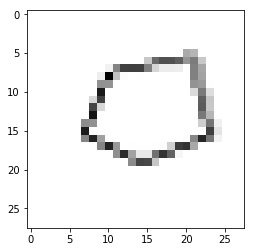

In [16]:
plt.imshow(show_image,cmap='gray')

In [17]:
#Train Loader is iterable
import collections
isinstance(train_loader,collections.Iterable)

True

In [18]:
isinstance(test_loader,collections.Iterable)

True

In [19]:
#batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [20]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Branch 1-Class
        self.cnnb1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relub1 = nn.ReLU()
        
        # Max pool 1
        self.maxpoolb1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
        self.fcb1 = nn.Linear(32 * 4 * 4, 10)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        #Branching
        class_label = self.cnnb1(out)
        class_label = self.relub1(class_label)
        class_label = self.maxpoolb1(class_label)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        class_label = class_label.view(class_label.size(0), -1)

        # Linear function (readout)
        order_label = self.fc1(out)
        class_label=self.fcb1(class_label)
        
        return class_label,order_label


In [21]:
model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, clabel,olabel) in enumerate(train_loader):
        images=images.float()
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            clabel = Variable(clabel.cuda())
            olabel = Variable(olabel.cuda())
        else:
            images = Variable(images)
            clabel = Variable(clabel)
            olabel = Variable(olabel)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        cpred,opred = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        closs = criterion(cpred, clabel)
        oloss = criterion(opred, olabel)
        
        # Getting gradients w.r.t. parameters
        closs.backward(retain_graph=True)
        oloss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            ccorrect = 0
            ctotal = 0
            ocorrect=0
            ototal=0
            # Iterate through test dataset
            for images, clabel,olabel in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                cpred,opred = model(images)
                
                # Get predictions from the maximum value
                _, cpredicted = torch.max(cpred.data, 1)
                _, opredicted = torch.max(opred.data, 1)
                
                # Total number of labels
                ctotal += clabel.size(0)
                ototal += olabel.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    ccorrect += (cpredicted.cpu() == clabel.cpu()).sum()
                    ocorrect += (opredicted.cpu() == olabel.cpu()).sum() 
                else:
                    ccorrect += (cpredicted == clabel).sum()
                    ocorrect += (opredicted == olabel).sum()
            
            caccuracy = 100 * ccorrect / ctotal
            oaccuracy = 100 * ocorrect / ototal
            
            # Print Loss
            print('Class:Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, closs.data[0], caccuracy))
            print('Order:Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, oloss.data[0], oaccuracy))

In [2]:
# # Training settings
# batch_size = 64

# # MNIST Dataset
# train_dataset = datasets.MNIST(root='./data/',
#                                train=True,
#                                transform=transforms.ToTensor(),
#                                download=True)

# test_dataset = datasets.MNIST(root='./data/',
#                               train=False,
#                               transform=transforms.ToTensor())

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,

#                                           shuffle=False)


In [41]:
np.array(train_dataset.__getitem__(2)).shape()

TypeError: only 1-element tensors can be converted to Python scalars

In [3]:
class Branched_CNN(nn.Module):

    def __init__(self, in_channels):
        super(Branched_CNN, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x.float())

        branch5x5 = self.branch5x5_1(x.float())
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3 = self.branch3x3_1(x.float())
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(88, 16, kernel_size=3)

        self.network1 = Branched_CNN(in_channels=64)
        self.network2 = Branched_CNN(in_channels=16)

        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2200,1600)
        self.fc2 = nn.Linear(1600,800)
        self.fc3 = nn.Linear(800,128)
        self.fc4 = nn.Linear(128,16)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x.float())))
       
        x = self.network1(x.float())
        x = F.relu(self.mp(self.conv2(x.float())))
        x = self.network2(x.float())
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return F.log_softmax(x)

In [5]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [6]:
model.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(88, 16, kernel_size=(3, 3), stride=(1, 1))
  (network1): Branched_CNN(
    (branch1x1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_pool): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (network2): Branched_CNN(
    (branch1x1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(16,

In [7]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        #print(target," :",output)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
for epoch in range(1, 2):
    train(epoch)
    test()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.779853
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.754137
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.712965
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.673273
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.655825
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.616606
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.560194
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.488868
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.403643
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.375280
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.358360
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.321087
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.317182
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.296776
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.296909
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.313634
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.291624
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.342213
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.318429
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.329705
Train Epoch: 1 [12800/60000 (